In [17]:
import torch
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

def loadData(fileName):
    data = []
    with open(fileName, 'r') as f:
        for line in f:
            row = list(map(float, line.strip().split(',')))
            data.append(row)
    return torch.tensor(data, dtype=torch.float32)

trainingSet = loadData("yeast_train.txt")
testingSet = loadData("yeast_test.txt")

In [18]:
def getDistance(x, y):
    return torch.sqrt(torch.sum((x - y) ** 2))

In [19]:
def getNeighbors(trainingSet, tester, k):
    distances = []
    for i in range(trainingSet.shape[0]):
        dist = getDistance(tester, trainingSet[i][:-1])
        distances.append((dist, trainingSet[i][-1], i))
    distances.sort(key=lambda x: (x[0], x[2]))

    neighbors = [distances[i][1].item() for i in range(k)]
    return neighbors

In [20]:
def guessClass(neighbors, classOrder):
    
    if(len(neighbors) > 1):
        
        labels = [label for label in neighbors]

        mostVotes = max(Counter(labels).values())
        options = [label for label, total in Counter(labels).items() if total == mostVotes]

        for cls in classOrder:
            if cls in options:
                return cls
    else:
        return neighbors[0]

In [21]:
def mykNN(trainingSet, testingSet, k):
    classOrder = []
    for label in trainingSet[:, -1]:
        if label not in classOrder:
            classOrder.append(label)

    predictions = []

    for i in range(testingSet.shape[0]):
        tester = testingSet[i, :-1]
        actual = testingSet[i, -1].item()
        neighbors = getNeighbors(trainingSet, tester[0], k)
        guess = guessClass(neighbors, classOrder)
        predictions.append((guess, actual))

    return predictions

In [22]:
def loocv(trainingSet, k):
    errors = []

    for i in range(trainingSet.shape[0]):
        trainer = torch.cat((trainingSet[:i], trainingSet[i+1:]))
        tester = trainingSet[i, :-1]

        predicted = mykNN(trainer, tester.unsqueeze(0), k)[0][0]
        actual = trainingSet[i, -1].item()

        errors.append(abs(predicted - actual))
    return sum(errors) / len(errors)

In [23]:
def runkNN(trainingSet, testingSet):
    
    errors = []
    
    for k in range(1,4):
        mae = loocv(trainingSet, k+1)
        errors.append((mae, k+1))
        
    errors.sort()
    bestK = errors[0][1]

    print(f"K chosen to be: {bestK}")

    predictions = mykNN(trainingSet, testingSet, bestK)

    correct = 0
    totalError = 0
    for guess, actual in predictions:
        if guess == actual:
            correct += 1
        totalError += abs(guess - actual)
    
    print(f"Predicted Class Label: {guess}, Actual Class Label: {actual}")
    print(f"Correctly Classified Instances: {correct}, Total Instances Predicted: {len(predictions)}")
    print(f"Mean Absolute Error: {totalError / len(predictions)}, Total Instances Predicted: {len(predictions)}")

In [ ]:
runkNN(trainingSet, testingSet)

In [31]:
def confMatrix(predictions):
    matrix = np.zeros((11,11), dtype=int)

    for guess, actual in predictions:
        matrix[int(actual)-1][int(guess)-1] += 1
    return matrix

In [33]:
def plotkNN(trainingSet, testingSet):
    accuracies = []

    kVals = [1,5,10,20,30]
    for k in kVals:
        predictions = mykNN(trainingSet, testingSet, k)
        if k == 1 or k == 30:
            matrix = confMatrix(predictions)
            print(f"Confusion Matrix for k={k}:\n{matrix}\n")
        correct = sum(1 for guess, actual in predictions if guess == actual)
        acc = correct / len(predictions)
        accuracies.append(acc)
    
    plt.plot(kVals, accuracies, marker="o")
    plt.xlabel("k")
    plt.ylabel("Test Accuracy")
    plt.title("Accuracy vs k on Yeast Dataset")
    plt.show()

Confusion Matrix for k=1:
[[41  2  0  0  1  0  0  0 37  0  0]
 [36  4  0  0 21  0  0  0 62  0  0]
 [51  9  0  0 16  0  0  0 62  0  0]
 [14  0  0  0  0  0  0  0  0  0  0]
 [15  0  0  0  1  0  0  0  2  0  0]
 [ 9  5  0  0  3  0  0  0 30  0  0]
 [10  0  0  0  0  0  0  0  0  0  0]
 [ 3  0  0  0  0  0  0  0  5  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 3  0  0  0  0  0  0  0  3  0  0]]

Confusion Matrix for k=30:
[[28 52  0  0  1  0  0  0  0  0  0]
 [26 83  0  0 14  0  0  0  0  0  0]
 [32 95  0  0 11  0  0  0  0  0  0]
 [14  0  0  0  0  0  0  0  0  0  0]
 [14  4  0  0  0  0  0  0  0  0  0]
 [ 4 40  0  0  3  0  0  0  0  0  0]
 [ 9  1  0  0  0  0  0  0  0  0  0]
 [ 2  6  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 3  3  0  0  0  0  0  0  0  0  0]]



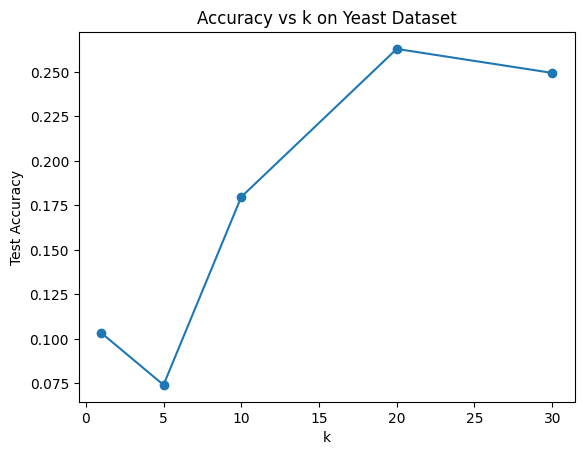

In [34]:
plotkNN(trainingSet, testingSet)